# House Prices - Advanced Regression Techniques
## Predict sales prices and practice feature engineering, RFs, and gradient boosting

https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques

ALWAYS start with setting out the approach:

1. explore the dataset: 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
pd.__version__

'2.0.3'

In [4]:
training = pd.read_csv('House_prices/train.csv')
training.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# 1. Explore the data

In [5]:
training.set_index('Id')
training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [6]:
training.isna().sum().sort_values(ascending=False)

PoolQC         1453
MiscFeature    1406
Alley          1369
Fence          1179
MasVnrType      872
               ... 
ExterQual         0
Exterior2nd       0
Exterior1st       0
RoofMatl          0
SalePrice         0
Length: 81, dtype: int64

In [7]:
training.SalePrice.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

<Axes: >

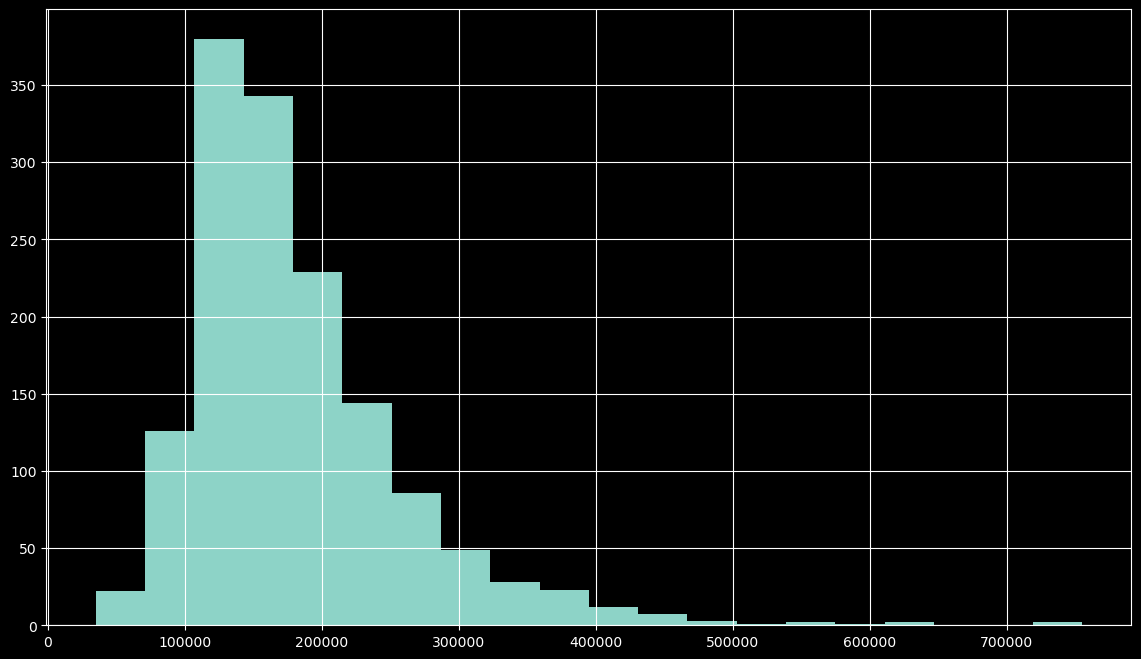

In [8]:
training['SalePrice'].hist(bins=20, figsize=(14,8))

## interesting improvement

a logarithmical transformation makes the dependent variable normally distributed - just remember to exp the results!

<Axes: >

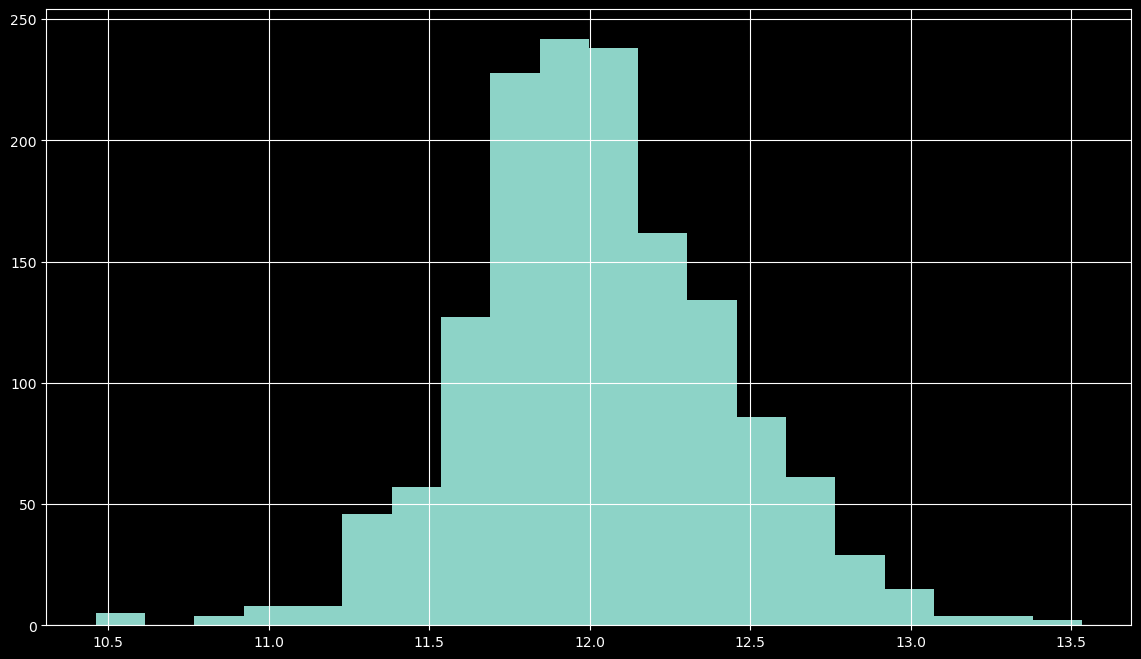

In [95]:
log_SalePrice = np.log(training['SalePrice'])
pd.Series(log_SalePrice).hist(bins=20, figsize=(14,8))

<Axes: >

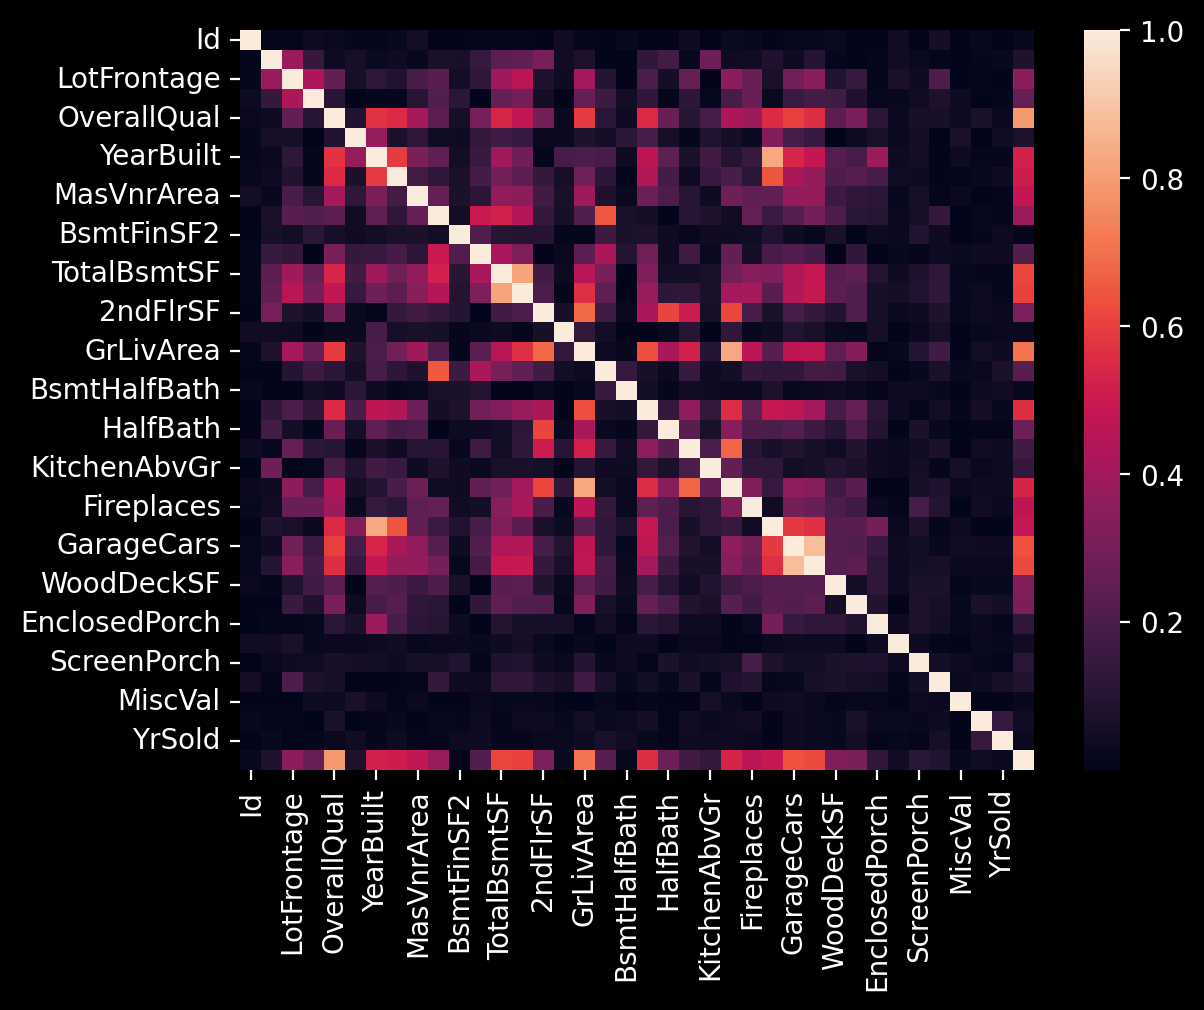

In [10]:
correlations = training.corr(numeric_only=True).abs()
plt.figure(dpi=200)
sns.heatmap(correlations)

## organise by type

- categorical and numerical
- years are continuious variables but are better interpreted as categories
  - prices go up and down over the years 
  - 'years since renovation' may be more significant

In [11]:
categorical = training.select_dtypes(include=['category', 'object'])
numerical = training.select_dtypes(include=['int64', 'float64'])

In [12]:
numerical.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,1460.0,730.500000,421.610009,1.0,365.75,730.5,1095.25,1460.0
MSSubClass,1460.0,56.897260,42.300571,20.0,20.00,50.0,70.00,190.0
LotFrontage,1201.0,70.049958,24.284752,21.0,59.00,69.0,80.00,313.0
LotArea,1460.0,10516.828082,9981.264932,1300.0,7553.50,9478.5,11601.50,215245.0
OverallQual,1460.0,6.099315,1.382997,1.0,5.00,6.0,7.00,10.0
OverallCond,1460.0,5.575342,1.112799,1.0,5.00,5.0,6.00,9.0
YearBuilt,1460.0,1971.267808,30.202904,1872.0,1954.00,1973.0,2000.00,2010.0
YearRemodAdd,1460.0,1984.865753,20.645407,1950.0,1967.00,1994.0,2004.00,2010.0
MasVnrArea,1452.0,103.685262,181.066207,0.0,0.00,0.0,166.00,1600.0
BsmtFinSF1,1460.0,443.639726,456.098091,0.0,0.00,383.5,712.25,5644.0


In [13]:
categorical.describe().T

,count,unique,top,freq
MSZoning,1460,5,RL,1151
Street,1460,2,Pave,1454
Alley,91,2,Grvl,50
LotShape,1460,4,Reg,925
LandContour,1460,4,Lvl,1311
Utilities,1460,2,AllPub,1459
LotConfig,1460,5,Inside,1052
LandSlope,1460,3,Gtl,1382
Neighborhood,1460,25,NAmes,225
Condition1,1460,9,Norm,1260


Refined:

I selected 43 categorical dtypes, but 60 categorical features, because several use numbers as codes.

YrSold, YearBuilt, etc should be replaced by bins.

In [14]:
categorical = ['Id', 'MSSubClass', 'MSZoning', 'Street', 'Alley', 
               'LotShape', 'LandContour', 'Utilities', 'LotConfig',
               'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
               'BldgType','HouseStyle', 'OverallQual', 'OverallCond', 
               'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl',
               'Exterior1st', 'Exterior2nd', 'MasVnrType','ExterQual', 
               'ExterCond', 'Foundation', 'BsmtQual','BsmtCond', 'BsmtExposure', 
               'BsmtFinType1', 'BsmtFinType2', 'Heating','HeatingQC', 
               'CentralAir', 'Electrical', 'KitchenQual','Functional', 
               'Fireplaces', 'FireplaceQu', 'GarageType','GarageYrBlt', 
               'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 
               'GarageCond', 'PavedDrive', 'EnclosedPorch', '3SsnPorch', 
               'ScreenPorch', 'PoolQC','Fence', 'MiscFeature', 
               'MiscVal', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition']


numerical =  ['SalePrice', 
              'GrLivArea', 'TotRmsAbvGrd', 
              # 'HalfBath', 'BedroomAbvGr',
            #   'KitchenAbvGr','BsmtFullBath', 'BsmtHalfBath', 'FullBath', 
            #   'LotFrontage', 'WoodDeckSF', 'OpenPorchSF', 'LowQualFinSF', 
              'BsmtFinSF1',
              # 'BsmtFinSF2', 
              'BsmtUnfSF', 'TotalBsmtSF', 
              # '1stFlrSF', '2ndFlrSF',
              'LotArea', 'MasVnrArea', 
              # 'PoolArea'
              ]

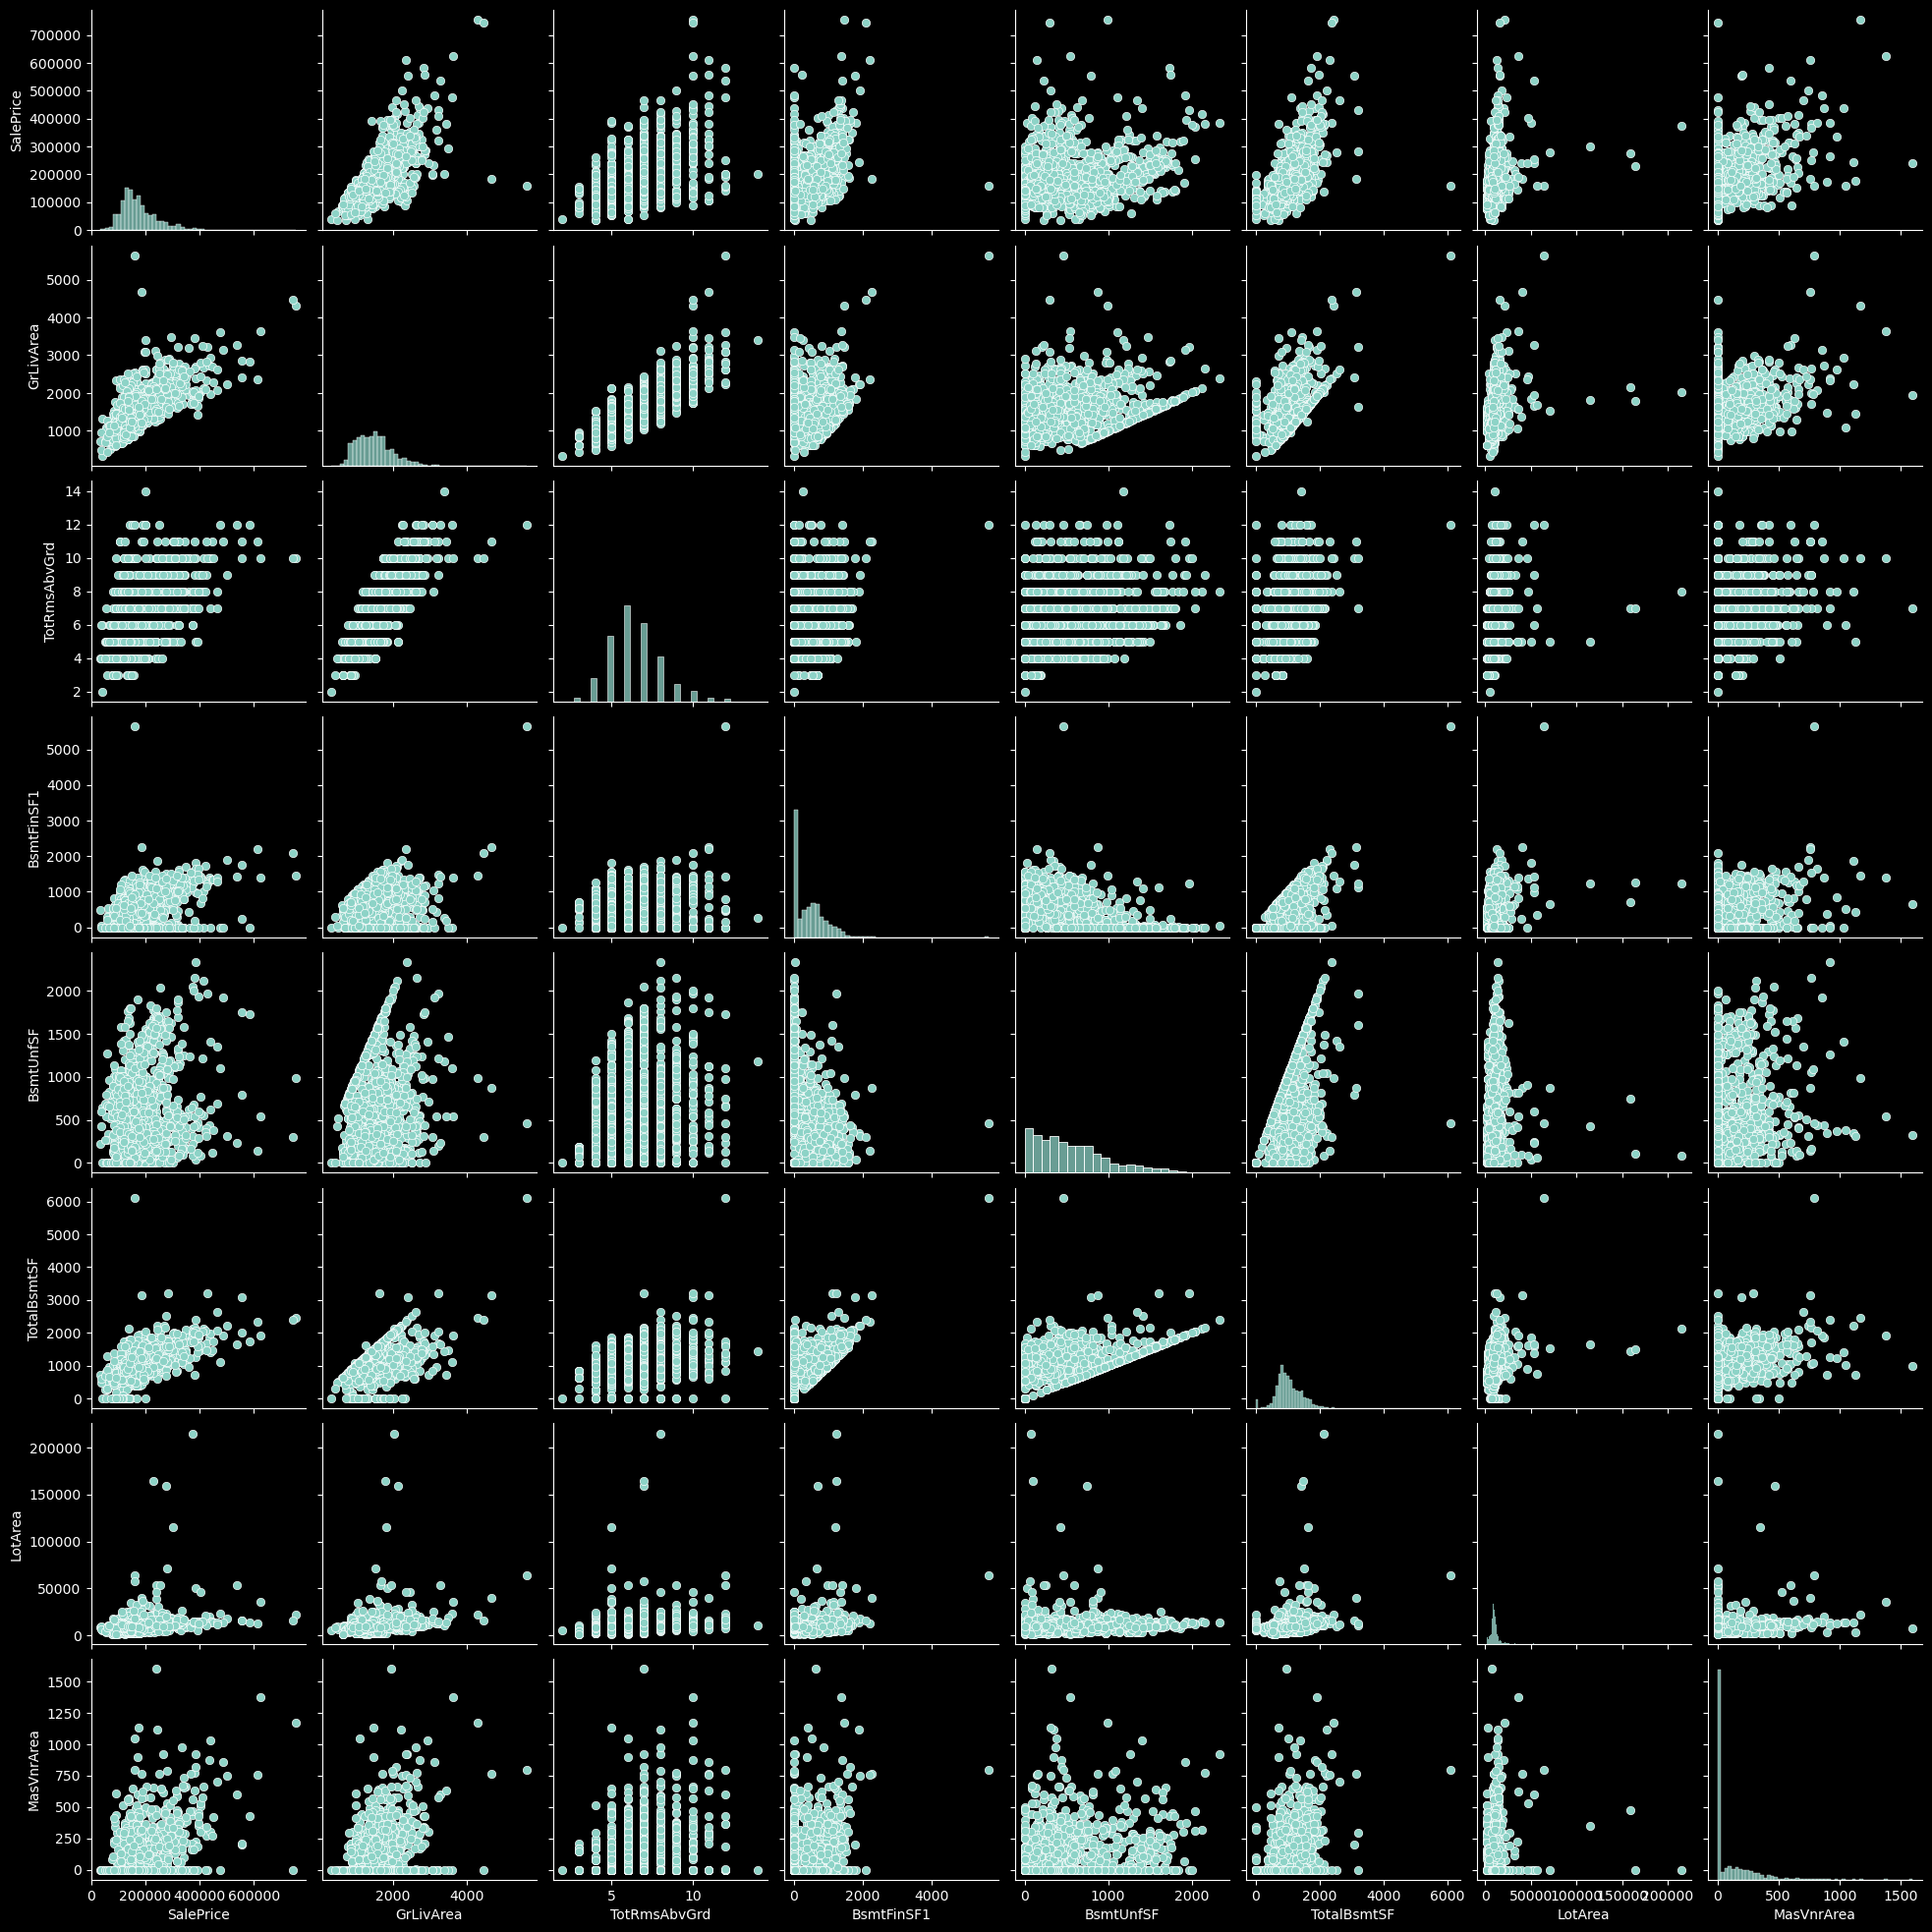

In [15]:
sns.pairplot(training[numerical])

```python
pd.pivot_table(training, index='SalePrice', columns=categorical[:5], aggfunc='count')
```
MemoryError: Unable to allocate 2.16 GiB for an array with shape (290394000,) and data type uint64

## Null values

In [88]:
nulls = training.isna().sum()
nulls = pd.DataFrame(nulls)
nulls['pct'] = training.isna().sum() / len(training) * 100
nulls = nulls.round(0).sort_values(by='pct', ascending=False)
nulls.head()

,0,pct
FireplaceQu,690,47.0
LotFrontage,259,18.0
GarageCond,81,6.0
GarageType,81,6.0
GarageFinish,81,6.0


In [26]:
nulls['pct'][:5].index

Index(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'MasVnrType'], dtype='object')

In [24]:
training = training.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'MasVnrType'], axis=1)

In [58]:
bad_cats = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'MasVnrType']
[categorical.remove(cat) for cat in bad_cats]

ValueError: list.remove(x): x not in list

In [61]:
'Alley' in categorical

False

# 2. Questions and hypopheses to ask the data

What is the effect on house price of:
- Dwelling type
- zoning
- street access
- property shape
- property age
- living area
- year to year

In [29]:
training.groupby('BldgType')['SalePrice'].mean().round()

BldgType
1Fam      185764.0
2fmCon    128432.0
Duplex    133541.0
Twnhs     135912.0
TwnhsE    181959.0
Name: SalePrice, dtype: float64

<Figure size 1400x800 with 0 Axes>

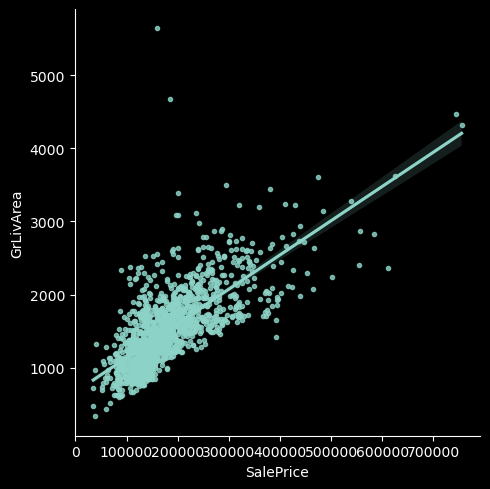

In [37]:
plt.figure(figsize=(14,8))
sns.lmplot(training, x='SalePrice', y='GrLivArea', markers='.')
plt.show()

# Preprocessing: pipeline

In [67]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

numerical_tf = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_tf = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

In [70]:
numerical_columns = training[numerical].select_dtypes(include=['int64', 'float64']).columns
numerical_columns = numerical_columns.drop('SalePrice')
categorical_columns = training[categorical].select_dtypes(include=['object', 'category']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_tf, numerical_columns),
        ('cat', categorical_tf, categorical_columns)
        ]
    )

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

In [96]:
X = training.drop('SalePrice', axis=1)
y = training['SalePrice'] # I could apply log here
y = log_SalePrice
X_preprocessed = pipeline.fit_transform(X)

# 3. Fit and parameter tuning

I've been following this https://www.youtube.com/watch?v=NQQ3DRdXAXE

In [97]:
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, train_test_split

# Define the models
models = {
    'LinearRegression': LinearRegression(),
    'RandomForest': RandomForestRegressor(random_state=42),
    'XGB': XGBRegressor(random_state=42)
}

cv = KFold(n_splits=3, shuffle=True)

param_grid = {
        'LinearRegression': {
                 'n_jobs': [1, 2]
                 },
        'RandomForest': {
                'n_estimators': [85,100,150],
                'max_depth': [3, 6]},
        'XGB': {
                'n_estimators': [85,100,150],
                'learning_rate': [0.01,0.1],
                'max_depth': [3, 6]}
}

grid = {}
for model_name, model in models.items():
        grid[model_name] = GridSearchCV(estimator=model, param_grid=param_grid[model_name], cv=cv, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)
        grid[model_name].fit(X_preprocessed, y)
        print([model_name], grid[model_name].best_params_)
        print([model_name], grid[model_name].best_score_)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
['LinearRegression'] {'n_jobs': 1}
['LinearRegression'] -1.7733425309085477e+19
Fitting 3 folds for each of 6 candidates, totalling 18 fits
['RandomForest'] {'max_depth': 6, 'n_estimators': 150}
['RandomForest'] -0.02827645408930476
Fitting 3 folds for each of 12 candidates, totalling 36 fits
['XGB'] {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 150}
['XGB'] -0.01925541349250305


In [99]:
grid = GridSearchCV(estimator=XGBRegressor(random_state=42), param_grid=param_grid['XGB'], cv=cv, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)

grid.fit(X_preprocessed, y)
print(grid.best_params_)
print(grid.best_score_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 150}
-0.01937470139515581


In [76]:
# from sklearn import metrics
# metrics.get_scorer_names()

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'matthews_corrcoef',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_negative_likelihood_ratio',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'positive_likelihood_ratio',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',

# next steps:

1. write out a dict of models and a dict in the param_grid with 



2. feature engineering - see https://youtube.com/clip/UgkxNsNQXP9DI2QTTQDrmXvIuNHbxCR1MtCP

3. ensembling

In [ ]:
categorical = ['Id', 'MSSubClass', 'MSZoning', 'Street', 'Alley', 
               'LotShape', 'LandContour', 'Utilities', 'LotConfig',
               'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
               'BldgType','HouseStyle', 'OverallQual', 'OverallCond', 
               'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl',
               'Exterior1st', 'Exterior2nd', 'MasVnrType','ExterQual', 
               'ExterCond', 'Foundation', 'BsmtQual','BsmtCond', 'BsmtExposure', 
               'BsmtFinType1', 'BsmtFinType2', 'Heating','HeatingQC', 
               'CentralAir', 'Electrical', 'KitchenQual','Functional', 
               'Fireplaces', 'FireplaceQu', 'GarageType','GarageYrBlt', 
               'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 
               'GarageCond', 'PavedDrive', 'EnclosedPorch', '3SsnPorch', 
               'ScreenPorch', 'PoolQC','Fence', 'MiscFeature', 
               'MiscVal', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition']



# 5. Submission

In [103]:
test = pd.read_csv('House_prices/test.csv')

X_test = pipeline.transform(test)

log_predictions = grid.predict(X_test)
predictions = np.exp(log_predictions)

In [126]:
results = pd.Series(predictions, index=test['Id'], name='SalePrice')

from datetime import datetime
timestamp = datetime.now().strftime('%d%m%y%S')

results.to_csv(f'House_prices/submission{timestamp}.csv') 

Id
1461    122517.500000
1462    162107.906250
1463    189675.578125
1464    187937.296875
1465    173066.625000
            ...      
2915     84059.734375
2916     93644.664062
2917    144038.000000
2918    118906.109375
2919    198450.062500
Name: SalePrice, Length: 1459, dtype: float32